In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [3]:
dataset = datasets.MNIST('.', download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FCFE7EB47D0>, 5)

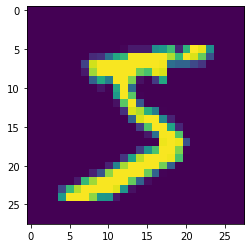

In [4]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [5]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [6]:
# Как формируется батча
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
      'target': target,
      }


In [7]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [8]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [9]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3052964210510254
epoch: 0, step: 200, loss: 0.2713976502418518
epoch: 0, step: 400, loss: 0.10304514318704605
epoch: 1, step: 0, loss: 0.1479598879814148
epoch: 1, step: 200, loss: 0.17482711374759674
epoch: 1, step: 400, loss: 0.21221333742141724
epoch: 2, step: 0, loss: 0.15428245067596436
epoch: 2, step: 200, loss: 0.09248725324869156
epoch: 2, step: 400, loss: 0.09600934386253357
epoch: 3, step: 0, loss: 0.0948513001203537
epoch: 3, step: 200, loss: 0.038135647773742676
epoch: 3, step: 400, loss: 0.0645100548863411
epoch: 4, step: 0, loss: 0.14457783102989197
epoch: 4, step: 200, loss: 0.0674213245511055
epoch: 4, step: 400, loss: 0.08098693192005157
epoch: 5, step: 0, loss: 0.06187509372830391
epoch: 5, step: 200, loss: 0.08196993917226791
epoch: 5, step: 400, loss: 0.04206104949116707
epoch: 6, step: 0, loss: 0.1325829029083252
epoch: 6, step: 200, loss: 0.06452899426221848
epoch: 6, step: 400, loss: 0.06245795264840126
epoch: 7, step: 0, loss: 0.035399

# Новый раздел

In [8]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1) 
    self.classifier = nn.Linear(5 * 14 *14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

In [5]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [6]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [9]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [12]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 0.05867321789264679
epoch: 0, step: 200, loss: 0.01914997212588787
epoch: 0, step: 400, loss: 0.05134234577417374
epoch: 1, step: 0, loss: 0.06331785023212433
epoch: 1, step: 200, loss: 0.05552620440721512
epoch: 1, step: 400, loss: 0.033696241676807404
epoch: 2, step: 0, loss: 0.053752243518829346
epoch: 2, step: 200, loss: 0.026188036426901817
epoch: 2, step: 400, loss: 0.045889243483543396
epoch: 3, step: 0, loss: 0.03863747790455818
epoch: 3, step: 200, loss: 0.031169826164841652
epoch: 3, step: 400, loss: 0.07099796086549759
epoch: 4, step: 0, loss: 0.0046123480424284935
epoch: 4, step: 200, loss: 0.006927969865500927
epoch: 4, step: 400, loss: 0.04468914121389389
epoch: 5, step: 0, loss: 0.019844936206936836
epoch: 5, step: 200, loss: 0.01777680404484272
epoch: 5, step: 400, loss: 0.0033077974803745747
epoch: 6, step: 0, loss: 0.042711276561021805
epoch: 6, step: 200, loss: 0.07950843870639801
epoch: 6, step: 400, loss: 0.0006803500582464039
epoch: 7, ste